In [ ]:
!pip install -q "tensorflow==2.11.*"
!pip install -q "tensorflow_io==0.28.*"

In [1]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import wave
import csv
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

In [2]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [3]:
@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav=tf.squeeze(wav,axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [4]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

In [129]:
_ = tf.keras.utils.get_file('car.zip',
                        'https://github.com/Boden448/Sound/archive/main.zip',

                        cache_dir='./',
                        cache_subdir='adds',
                        extract=True)

   8192/Unknown - 0s 0s/step

In [130]:
meta_csv='./adds/Sound-main/meta/car.csv'
base_data_path='./adds/Sound-main/photo/'

In [131]:
pd_data = pd.read_csv(meta_csv)
pd_data.head()

,filename,fold,target,category,risk
0,break1.wav,1,0,break,high
1,break2.wav,1,0,break,high
2,break3.wav,1,0,break,high
3,break4.wav,1,0,break,high
4,break5.wav,1,0,break,high


In [132]:
my_classes = ['horn','start','break','cat','siren','bird','construction','barrier','crowd']
map_class_to_id = {'horn':0,'start':1,'break':2,'cat':3,'siren':4,'bird':5,'construction':6,'barrier':7,'crowd':8}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filtered_pd.head(10)

,filename,fold,target,category,risk
0,./adds/Sound-main/photo/break1.wav,1,2,break,high
1,./adds/Sound-main/photo/break2.wav,1,2,break,high
2,./adds/Sound-main/photo/break3.wav,1,2,break,high
3,./adds/Sound-main/photo/break4.wav,1,2,break,high
4,./adds/Sound-main/photo/break5.wav,1,2,break,high
5,./adds/Sound-main/photo/break6.wav,1,2,break,high
6,./adds/Sound-main/photo/break8.wav,1,2,break,high
7,./adds/Sound-main/photo/break9.wav,1,2,break,high
8,./adds/Sound-main/photo/break10.wav,1,2,break,high
9,./adds/Sound-main/photo/break11.wav,1,2,break,high


In [133]:
filenames = filtered_pd['filename']
targets = filtered_pd['target']
folds = filtered_pd['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [134]:
def load_wav_for_map(filename, label, fold):
    return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [135]:
def extract_embedding(wav_data, label, fold):
    ''' run YAMNet to extract embedding from the wav data '''
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [136]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(64).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(64).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(64).prefetch(tf.data.AUTOTUNE)


In [137]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float64,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='softmax'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 512)               524800    
                                                                 
 dense_11 (Dense)            (None, 9)                 4617      
                                                                 
Total params: 529,417
Trainable params: 529,417
Non-trainable params: 0
_________________________________________________________________


In [138]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])


callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=4,
                                            baseline=None,
                                            restore_best_weights=True)



In [186]:
for i in range(1):
    history = my_model.fit(train_ds,
                           epochs=400,
                           validation_data=val_ds,
                           callbacks=callback)
    


Epoch 1/400
9/9 [==============================] - 0s 25ms/step - loss: 0.3067 - accuracy: 0.8844
Epoch 2/400
9/9 [==============================] - 0s 15ms/step - loss: 0.3058 - accuracy: 0.8844
Epoch 3/400
9/9 [==============================] - 0s 15ms/step - loss: 0.3050 - accuracy: 0.8844
Epoch 4/400
9/9 [==============================] - 0s 16ms/step - loss: 0.3042 - accuracy: 0.8844
Epoch 5/400
9/9 [==============================] - 0s 16ms/step - loss: 0.3033 - accuracy: 0.8844
Epoch 6/400
9/9 [==============================] - 0s 15ms/step - loss: 0.3025 - accuracy: 0.8844
Epoch 7/400
9/9 [==============================] - 0s 16ms/step - loss: 0.3017 - accuracy: 0.8844
Epoch 8/400
9/9 [==============================] - 0s 16ms/step - loss: 0.3009 - accuracy: 0.8844
Epoch 9/400
9/9 [==============================] - 0s 15ms/step - loss: 0.3001 - accuracy: 0.8844
Epoch 10/400
9/9 [==============================] - 0s 15ms/step - loss: 0.2993 - accuracy: 0.8844
Epoch 11/400
9/9 [=

9/9 [==============================] - 0s 15ms/step - loss: 0.2547 - accuracy: 0.8844
Epoch 84/400
9/9 [==============================] - 0s 15ms/step - loss: 0.2543 - accuracy: 0.8844
Epoch 85/400
9/9 [==============================] - 0s 14ms/step - loss: 0.2538 - accuracy: 0.8844
Epoch 86/400
9/9 [==============================] - 0s 14ms/step - loss: 0.2534 - accuracy: 0.8844
Epoch 87/400
9/9 [==============================] - 0s 15ms/step - loss: 0.2529 - accuracy: 0.8844
Epoch 88/400
9/9 [==============================] - 0s 15ms/step - loss: 0.2525 - accuracy: 0.8844
Epoch 89/400
9/9 [==============================] - 0s 15ms/step - loss: 0.2521 - accuracy: 0.8844
Epoch 90/400
9/9 [==============================] - 0s 15ms/step - loss: 0.2516 - accuracy: 0.8844
Epoch 91/400
9/9 [==============================] - 0s 15ms/step - loss: 0.2512 - accuracy: 0.8844
Epoch 92/400
9/9 [==============================] - 0s 15ms/step - loss: 0.2508 - accuracy: 0.8844
Epoch 93/400
9/9 [=====

9/9 [==============================] - 0s 17ms/step - loss: 0.2254 - accuracy: 0.8844
Epoch 166/400
9/9 [==============================] - 0s 16ms/step - loss: 0.2252 - accuracy: 0.8844
Epoch 167/400
9/9 [==============================] - 0s 15ms/step - loss: 0.2249 - accuracy: 0.8844
Epoch 168/400
9/9 [==============================] - 0s 15ms/step - loss: 0.2246 - accuracy: 0.8844
Epoch 169/400
9/9 [==============================] - 0s 15ms/step - loss: 0.2244 - accuracy: 0.8844
Epoch 170/400
9/9 [==============================] - 0s 14ms/step - loss: 0.2241 - accuracy: 0.8844
Epoch 171/400
9/9 [==============================] - 0s 15ms/step - loss: 0.2238 - accuracy: 0.8844
Epoch 172/400
9/9 [==============================] - 0s 17ms/step - loss: 0.2236 - accuracy: 0.8844
Epoch 173/400
9/9 [==============================] - 0s 15ms/step - loss: 0.2233 - accuracy: 0.8844
Epoch 174/400
9/9 [==============================] - 0s 16ms/step - loss: 0.2230 - accuracy: 0.8844
Epoch 175/400


9/9 [==============================] - 0s 15ms/step - loss: 0.2075 - accuracy: 0.8844
Epoch 248/400
9/9 [==============================] - 0s 16ms/step - loss: 0.2073 - accuracy: 0.8844
Epoch 249/400
9/9 [==============================] - 0s 15ms/step - loss: 0.2072 - accuracy: 0.8844
Epoch 250/400
9/9 [==============================] - 0s 16ms/step - loss: 0.2070 - accuracy: 0.8844
Epoch 251/400
9/9 [==============================] - 0s 15ms/step - loss: 0.2068 - accuracy: 0.8844
Epoch 252/400
9/9 [==============================] - 0s 15ms/step - loss: 0.2067 - accuracy: 0.8844
Epoch 253/400
9/9 [==============================] - 0s 15ms/step - loss: 0.2065 - accuracy: 0.8844
Epoch 254/400
9/9 [==============================] - 0s 15ms/step - loss: 0.2063 - accuracy: 0.8844
Epoch 255/400
9/9 [==============================] - 0s 15ms/step - loss: 0.2062 - accuracy: 0.8844
Epoch 256/400
9/9 [==============================] - 0s 15ms/step - loss: 0.2060 - accuracy: 0.8844
Epoch 257/400


9/9 [==============================] - 0s 15ms/step - loss: 0.1956 - accuracy: 0.8844
Epoch 330/400
9/9 [==============================] - 0s 15ms/step - loss: 0.1954 - accuracy: 0.8844
Epoch 331/400
9/9 [==============================] - 0s 16ms/step - loss: 0.1952 - accuracy: 0.8844
Epoch 332/400
9/9 [==============================] - 0s 18ms/step - loss: 0.1950 - accuracy: 0.8844
Epoch 333/400
9/9 [==============================] - 0s 16ms/step - loss: 0.1948 - accuracy: 0.8844
Epoch 334/400
9/9 [==============================] - 0s 15ms/step - loss: 0.1946 - accuracy: 0.8844
Epoch 335/400
9/9 [==============================] - 0s 15ms/step - loss: 0.1943 - accuracy: 0.8844
Epoch 336/400
9/9 [==============================] - 0s 15ms/step - loss: 0.1941 - accuracy: 0.8844
Epoch 337/400
9/9 [==============================] - 0s 15ms/step - loss: 0.1939 - accuracy: 0.8844
Epoch 338/400
9/9 [==============================] - 0s 15ms/step - loss: 0.1936 - accuracy: 0.8844
Epoch 339/400


In [187]:
class ReduceMeanLayer(tf.keras.layers.Layer):
    def __init__(self, axis=0, **kwargs):
        super(ReduceMeanLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, input):
        return tf.math.reduce_mean(input, axis=self.axis)

In [188]:
testing_wav_file_name = tf.keras.utils.get_file('miaow_16k.wav',
                                                'https://storage.googleapis.com/audioset/miaow_16k.wav',
                                                cache_dir='./',
                                                cache_subdir='test_data')

print(testing_wav_file_name)

testing_wav_data = load_wav_16k_mono(testing_wav_file_name)

./test_data\miaow_16k.wav


In [189]:
class ReduceMeanLayer(tf.keras.layers.Layer):
    def __init__(self, axis=0, **kwargs):
        super(ReduceMeanLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, input):
        return tf.math.reduce_mean(input, axis=self.axis)

In [190]:
saved_model_path = './dogs_cos_pigs'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./dogs_cos_pigs\assets


INFO:tensorflow:Assets written to: ./dogs_cos_pigs\assets


In [191]:
reloaded_model = tf.saved_model.load(saved_model_path)

./adds/Sound-main/photo/start17.wav


Waveform values: [-4.0204307e-07  1.2648238e-06 -1.6282337e-06 ... -5.9794016e-02
 -3.8953874e-02 -1.9528799e-02]


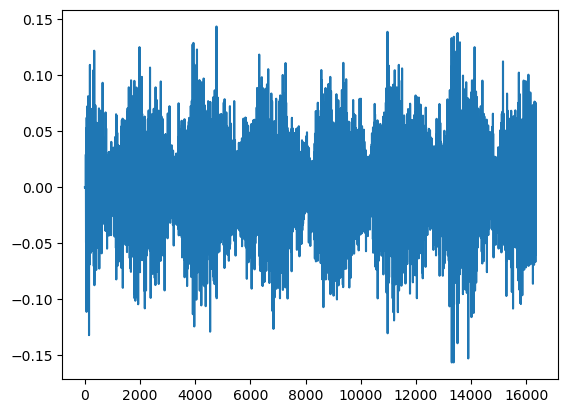

In [213]:
test_pd = filtered_pd.loc[filtered_pd['fold'] == 1]
row = test_pd.sample(1)
risk = row['risk'].item()
filename = row['filename'].item()
print(filename)
waveform = load_wav_16k_mono(filename)
print(f'Waveform values: {waveform}')
_ = plt.plot(waveform)

display.Audio(waveform, rate=16000)

In [214]:
reloaded_results = reloaded_model(waveform)
your_top_class = tf.math.argmax(reloaded_results)
your_inferred_class = my_classes[your_top_class]
class_probabilities = tf.nn.softmax(reloaded_results, axis=-1)
your_top_score = class_probabilities[your_top_class]
print(f'[Your model] The main sound is: {your_inferred_class} ({your_top_score})')
print(f'risk level: {risk}')

[Your model] The main sound is: start (0.6605525016784668)
risk level: low
